In [6]:
import os
import shutil
import subprocess
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
print(rdkit.__version__)
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol

from src.util import calc_rmsd_single_mol
from src.util import optimize_molecule

PATH = os.getcwd()

2024.03.3


## Read molecule first

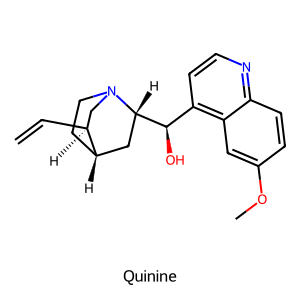

In [7]:
# Lets read our dataset of molecules as pandas dataframe
file_path = os.path.join(PATH, 'data', 'molecules.csv')
dataset = pd.read_csv(file_path)

mol_list = []

# Lets draw all molecules and their trivial names on a single image
for i, row in dataset.iterrows():
    smiles = row['smiles']
    name = row['name']
    if name == 'Quinine':
        mol = Chem.MolFromSmiles(smiles)
        mol.SetProp("_Name", name)
        mol_list.append(mol)

legends = [mol.GetProp('_Name') for mol in mol_list]
Draw.MolsToGridImage(mol_list, molsPerRow= 1, subImgSize=(300,300), legends=legends, returnPNG=False)

## Generate 3D conformers for a given molecule using RDKit's ETKDG method

In [12]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol


from src.util import calc_rmsd_matrix_single_mol

# this is a spin off idea i wantred to test
quinine_params = AllChem.EmbedParameters()
quinine_params.randomSeed = 42
quinine_params.numThreads = 4
quinine_params.timeout = 100
quinine_params.clearConfs = True
quinine_params.onlyHeavyAtomsForRMS = True
quinine_params.useRandomCoords = True
quinine_params.enforceChirality = True
quinine_params.pruneRmsThresh = 0.1

quinine_NUM_CONFS = 300

quinine = mol_list[0]
quinine_3D = Chem.AddHs(quinine)
AllChem.EmbedMultipleConfs(quinine_3D, quinine_NUM_CONFS, quinine_params)
print(quinine_3D.GetNumConformers())
IPythonConsole.drawMol3D(quinine_3D, confId=-1)


300


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Calculate single point energies of all conformers using xTB

In [ ]:
from src.util import xtb_SP
from src.util import conformer_search
quinine_xtb = xtb_SP(quinine_3D)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:51<00:00,  2.69it/s]

[0.05099342348300695, 0.11711393705100193, 0.01694722223800227, 0.07792077000999598, 0.10778587112700677, 0.08970919361900087, 0.09007733452500588, 0.14653961754700617, 0.05153278851300058, 0.11165849478099688, 0.028391171864001308, 0.026353089203993818, 0.12334971102400516, 0.07811720630400032, 0.10708065430100078, 0.10988420794599563, 0.06672696663399336, 0.03132704005500386, 0.053153741808998234, 0.012915918632998569, 0.13807717204599612, 0.07006385827999395, 0.10658462228700216, 0.04506773669299946, 0.08855416417399908, 0.06720598889299367, 0.14410903150100296, 0.07443818978499905, 0.1359879141169955, 0.09481960190299787, 0.11563379431700582, 0.09748630759500543, 0.12419456572699517, 0.08427926576699463, 0.07208770968199474, 0.12076105402499593, 0.06446845740100571, 0.07013966303399854, 0.12993763184600482, 0.07362622816900455, 0.016174052634994496, 0.07478012170699344, 0.07930757305500435, 0.1374395099889938, 0.015549614631993336, 0.12001567470099417, 0.16747563987000547, 0.105289

In [13]:
from src.util import save_multiconf_sdf
quinine_xtb_filepath = os.path.join(PATH, 'data', 'quinine_xtb.sdf')
save_multiconf_sdf(quinine_xtb, quinine_xtb_filepath)

In [14]:
from src.util import read_multiconf_sdf
quinine_xtb_filepath = os.path.join(PATH, 'data', 'quinine_xtb.sdf')
quinine_xtb = read_multiconf_sdf(quinine_xtb_filepath)
IPythonConsole.drawMol3D(quinine_xtb, confId=-1)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
energies = []
for conf in quinine_xtb.GetConformers():
    energies.append(conf.GetDoubleProp('conf_energy'))

minE = min(energies)
energies = [E - minE for E in energies]
print(energies)
print(np.mean(energies))

[0.05099342348300695, 0.11711393705100193, 0.01694722223800227, 0.07792077000999598, 0.10778587112700677, 0.08970919361900087, 0.09007733452500588, 0.14653961754700617, 0.05153278851300058, 0.11165849478099688, 0.028391171864001308, 0.026353089203993818, 0.12334971102299619, 0.07811720630400032, 0.10708065430100078, 0.10988420794599563, 0.06672696663399336, 0.03132704005500386, 0.053153741808998234, 0.012915918632998569, 0.13807717204599612, 0.07006385827999395, 0.10658462228700216, 0.04506773669299946, 0.08855416417399908, 0.06720598889299367, 0.14410903150100296, 0.07443818978499905, 0.1359879141169955, 0.09481960190299787, 0.11563379431700582, 0.09748630759500543, 0.12419456572699517, 0.08427926576699463, 0.07208770968199474, 0.12076105402499593, 0.06446845740100571, 0.07013966303399854, 0.12993763184600482, 0.07362622816900455, 0.016174052634994496, 0.07478012170699344, 0.07930757305500435, 0.1374395099889938, 0.015549614631993336, 0.12001567470099417, 0.16747563987000547, 0.105289

## Calculate a matrix of RMSD values between all conformers

In [ ]:
rmsds_matrix = calc_rmsd_matrix_single_mol(quinine_3D)
lower_triangle_indices = np.tril_indices_from(rmsds_matrix, k=-1)
rmsds = rmsds_matrix[lower_triangle_indices]

In [ ]:
# --- 2. Plotting the heatmap ---
fig, ax = plt.subplots(figsize=(5, 5))

# Use imshow to create the heatmap
# cmap='magma' sets the color scheme
im = ax.imshow(rmsds_matrix, cmap='magma')

# --- 3. Adding a color bar ---
# This shows the mapping of colors to values
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Distance", rotation=-90, va="bottom")


# --- 5. Final Touches ---
ax.set_title(f"Conformer RMSD Heatmap")

tick_spacing = 25
ax.set_xticks(np.arange(0, len(rmsds_matrix), tick_spacing))
ax.set_yticks(np.arange(0, len(rmsds_matrix), tick_spacing))

ax.set_xlabel("Index")
ax.set_ylabel("Index")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Your data ---
# This is a sample list of float values.
# Replace this with your actual data.
# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))

# Plot the density histogram
ax.hist(rmsds, bins=30, alpha=0.7, label='_nolegend_')

# --- Calculate and plot statistics ---
mean = np.mean(rmsds)
std = np.std(rmsds)

# --- Plot Mean Line and Standard Deviation Box ---

# Add a semi-transparent background box for +- 1 standard deviation
ax.axvspan(mean - std, mean + std, alpha=0.3, color='orange', label=f'±Std Dev Range')

# Plot vertical line for the mean on top of the box
ax.axvline(mean, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')


# --- Final Touches ---
ax.set_title('Distribution with Mean and Standard Deviation Range')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend() # Display the legend
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rmsds_matrix_filepath = os.path.join(PATH, 'data', 'rmsds_matrix.npy')
np.save(rmsds_matrix_filepath, rmsds_matrix)

## Using the RMSD matrix embed all conformers into 2D TSNE

In [16]:
rmsds_matrix_filepath = os.path.join(PATH, 'data', 'rmsds_matrix.npy')
rmsds_matrix = np.load(rmsds_matrix_filepath)

Attempting to use `pca` initalization, but using precomputed distance matrix! Using `spectral` initilization instead, which doesn't need access to the data matrix.


Fitting t-SNE model...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='precomputed', n_jobs=-1, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating spectral initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=25.00 for 250 iterations...
Iteration   50, KL divergence -0.7370, 50 iterations in 22.4163 sec
Iteration  100, KL divergence 2.2594, 50 iterations in 1.5409 sec
Iteration  150, KL divergence 2.2594, 50 iterations in 0.5141 sec
Iteration  200, KL divergence 2.2594, 50 iterations in 0.6608 sec
Iteration  250, KL divergence 2.2594, 50 iterations in 0.4940 sec
   --> Time elapsed: 25.63 seconds
===> Running optimization with exaggeration=1.00, lr=300.00 for 500 iterations...
Iteration   50, KL divergence 1.1446, 5

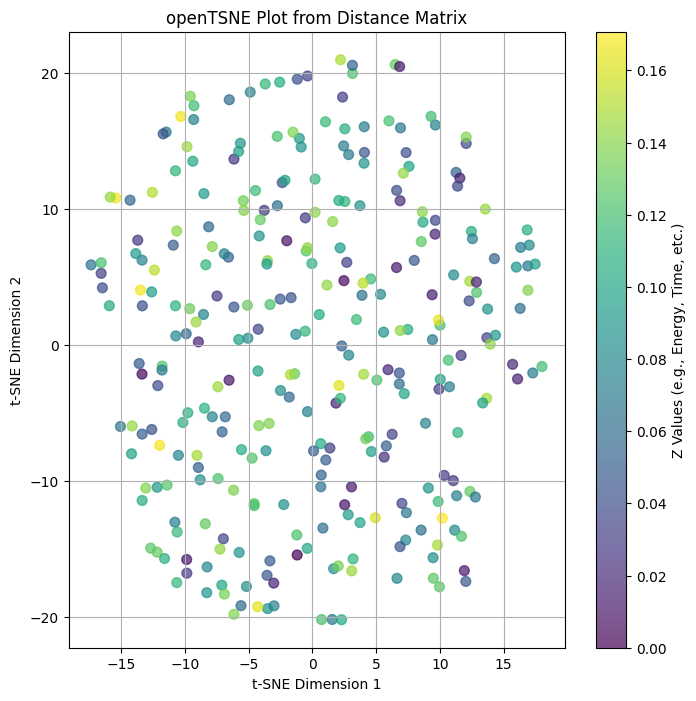

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

# --- 2. Fit openTSNE ---
# Initialize TSNE with metric="precomputed". This is the crucial step.
# You can also adjust other parameters like perplexity, n_iter, etc.
print("Fitting t-SNE model...")
tsne = TSNE(
    perplexity=30,
    metric="precomputed",
    n_jobs=-1, # Use all available CPU cores
    random_state=42,
    verbose=True
)

# Fit the model on the distance matrix to get the 2D embedding
embedding = tsne.fit(rmsds_matrix)
print("Fitting complete.")

xs, ys = embedding[:, 0], embedding[:, 1]
zs = energies

# --- 3. Plot the Results ---
print("Plotting the embedding...")
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(xs, ys, c=zs, s=50, alpha=0.7, cmap='viridis')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Z Values (e.g., Energy, Time, etc.)')

ax.set_title('openTSNE Plot from Distance Matrix')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.grid(True)
plt.show()

## Plot conformers into 3D space, where x and y coordinates are TSNE embeddings, and z coordinate is relative energies of each conformer (dE)

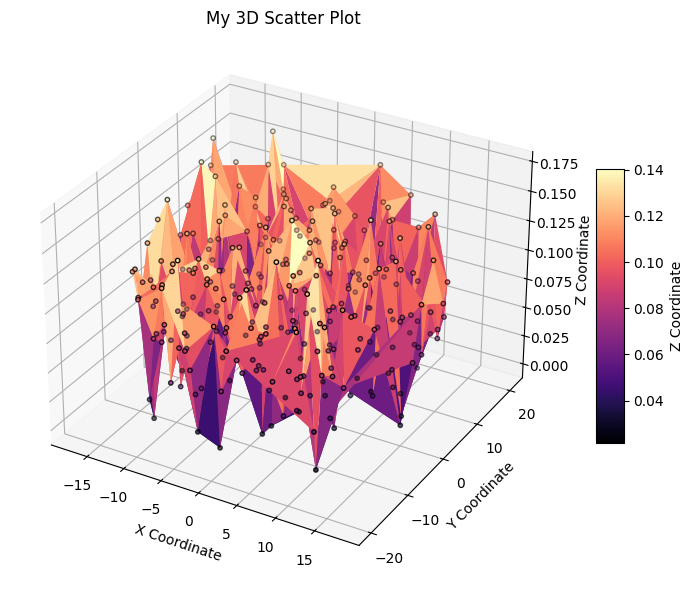

In [18]:
# This import registers the 3D projection, but is not used directly.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. PREPARE YOUR DATA
# Replace these with your own lists of coordinates
# For this example, we'll create a simple helix.

# 2. CREATE THE 3D PLOT
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')


# 3. PLOT THE DATA
surf = ax.plot_trisurf(xs, ys, zs, cmap=cm.magma, linewidth=0.1, antialiased=True)

# The scatter plot is commented out for a cleaner look, but you can re-enable it.
ax.scatter(xs, ys, zs, c=zs, edgecolors='black', linewidths=1, s=10, cmap='magma')


# 4. ADD A COLOR BAR
# The color bar shows the mapping from Z-values to the 'magma' colormap.
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Z Coordinate')

# 4. CUSTOMIZE THE PLOT
ax.set_title("My 3D Scatter Plot")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")

# 5. SHOW THE PLOT
plt.tight_layout()
plt.show()

## Lets find global and local minimas on the energy landscape

--- Analysis Results ---
Global Minimum Point: {'x': -1.1921286221805916, 'y': -15.452077564974283, 'z': 0.0}
Local Minima Points: [{'x': 2.304795297282636, 'y': -0.09028100399304237, 'z': 0.05153278851300058}, {'x': -6.147623013533959, 'y': 13.641011305051732, 'z': 0.026353089203993818}, {'x': 9.395142594860172, 'y': 3.6734183509287837, 'z': 0.012915918632998569}, {'x': -10.779611710511645, 'y': -13.04167320099351, 'z': 0.07208770968199474}, {'x': 1.8547789747384227, 'y': -4.290035654860835, 'z': 0.016174052634994496}, {'x': 16.097796521099582, 'y': -2.515416059960105, 'z': 0.015549614631993336}, {'x': -9.857882084490784, 'y': -15.786108420615857, 'z': 0.008996795043003658}, {'x': -8.130579068705298, 'y': 8.668311994835438, 'z': 0.056405655042993885}, {'x': -2.359537717313323, 'y': 11.914652088202057, 'z': 0.03855180538900527}, {'x': 6.25981934473586, 'y': -6.581292266278612, 'z': 0.03351435573999595}, {'x': 7.355084774429877, 'y': 14.121038773995348, 'z': 0.04216442470500681}, {'x': 

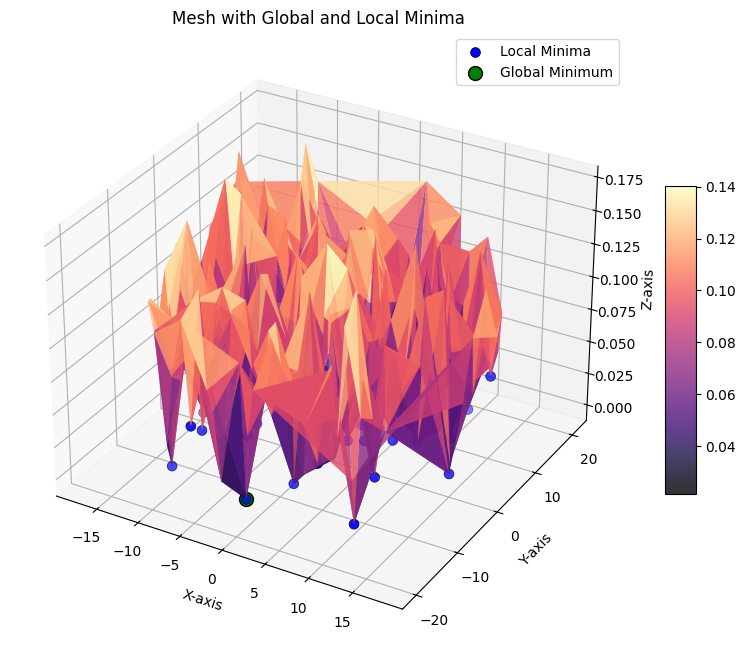

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.tri import Triangulation

def find_minima_on_mesh(vertices, triangles):
    """
    Finds the global minimum point and all local minima points on a mesh.

    Args:
        vertices (list): A list of vertex dictionaries, e.g., [{'x': x1, 'y': y1, 'z': z1}, ...].
        triangles (list): A list of triangles, where each triangle is a list/tuple
                          of 3 integer indices referring to vertices.

    Returns:
        tuple: A tuple containing:
            - dict: The global minimum point as {'x': x, 'y': y, 'z': z}.
            - list: A list of local minimum points, each as {'x': x, 'y': y, 'z': z}.
    """
    if not vertices:
        return None, []

    num_vertices = len(vertices)

    # 1. Compute Vertex Neighbors
    vertex_neighbors = {i: set() for i in range(num_vertices)}

    for tri in triangles:
        v0, v1, v2 = tri[0], tri[1], tri[2]

        # Add mutual neighbors
        vertex_neighbors[v0].add(v1)
        vertex_neighbors[v0].add(v2)

        vertex_neighbors[v1].add(v0)
        vertex_neighbors[v1].add(v2)

        vertex_neighbors[v2].add(v0)
        vertex_neighbors[v2].add(v1)

    # 2. Find the Global Minimum
    global_min_z = float('inf')
    global_minimum_point = None

    for i, vert in enumerate(vertices):
        if vert['z'] < global_min_z:
            global_min_z = vert['z']
            global_minimum_point = vert

    # 3. Find Local Minima
    local_minima_points = []

    for i in range(num_vertices):
        current_vertex_z = vertices[i]['z']
        is_local_minimum = True

        # Check if any neighbor has a strictly lower Z value
        for neighbor_idx in vertex_neighbors[i]:
            if vertices[neighbor_idx]['z'] < current_vertex_z:
                is_local_minimum = False
                break # Not a local minimum, move to the next vertex

        if is_local_minimum:
            local_minima_points.append(vertices[i])

    return global_minimum_point, local_minima_points

# --- How to get the mesh/triangles from xs, ys, zs ---

# 1. Prepare your vertices list of dictionaries
vertices = [{'x': xs[i], 'y': ys[i], 'z': zs[i]} for i in range(len(xs))]

# 2. Use Triangulation to get the triangles (simplices)
# This performs a Delaunay triangulation on the (x, y) points.
triang = Triangulation(xs, ys)
triangles = triang.get_masked_triangles() # Corrected line # These are the indices of vertices forming each triangle

# 3. Call the find_minima_on_mesh function
global_min, local_mins = find_minima_on_mesh(vertices, triangles)

print("--- Analysis Results ---")
print(f"Global Minimum Point: {global_min}")
print(f"Local Minima Points: {local_mins}")

# --- Optional: Visualize the found minima on the plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original surface
surf = ax.plot_trisurf(xs, ys, zs, cmap=cm.magma, linewidth=0.1, antialiased=True, alpha=0.8)

# Mark all local minima
if local_mins:
    local_min_x = [p['x'] for p in local_mins]
    local_min_y = [p['y'] for p in local_mins]
    local_min_z = [p['z'] for p in local_mins]
    ax.scatter(local_min_x, local_min_y, local_min_z,
               color='blue', s=50, label='Local Minima', edgecolors='black', linewidth=0.5)
    

# Mark the global minimum
if global_min:
    ax.scatter(global_min['x'], global_min['y'], global_min['z'],
               color='green', s=100, label='Global Minimum', edgecolors='black', linewidth=1)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Mesh with Global and Local Minima')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.legend()
plt.show()

## Now lets optimize all these 300 conformers to get better better minimas

In [26]:
## Optimize all conformers using xtb, sort out conformers based on RMSD
## plot all original conformers and now newly optimized conformers with all their steps on a single 3D plot landscape 
# (consider adding xtb optimization trails for conformers)

## plot all of that on TSNE (projection from above)
## plot all of that bananas

In [ ]:
ref_mol = Chem.Mol(quinine_3D)
combined_mol = Chem.Mol(ref_mol)

mols_list = [quinine_3D,]*quinine_3D.GetNumConformers()
for i, mol in enumerate(tqdm(mols_list)):
    if i == 0: 
        ref_mol.RemoveAllConformers()
        conf = quinine_3D.GetConformer(i)
        ref_mol.AddConformer(conf)
        continue

    mol.RemoveAllConformers()
    conf = quinine_3D.GetConformer(i)
    mol.AddConformer(conf)
    
    # Align each molecule to the reference
    Chem.rdMolAlign.AlignMol(mol, ref_mol, prbCid=-1, refCid=-1)

    combined_mol = Chem.CombineMols(combined_mol, mol)
    
# Visualize in 3D viewer
IPythonConsole.drawMol3D(combined_mol)
